------------


## Separación de digitos de varios modelos.

Usando mnist como dataset
Encontrados 6 pares de modelos.

🧩 Cargando modelos para configuración: 128_lat_2_mnist.keras

✅ Modelo '128_lat_2_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 128_lat_64_mnist.keras
✅ Modelo '128_lat_64_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 128_lat_64_mnist_beta_10.keras
✅ Modelo '128_lat_64_mnist_beta_10.keras' procesado.

🧩 Cargando modelos para configuración: 256_lat_128_mnist.keras
✅ Modelo '256_lat_128_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 256_lat_64_mnist.keras
✅ Modelo '256_lat_64_mnist.keras' procesado.

🧩 Cargando modelos para configuración: 512_lat_256_mnist.keras
✅ Modelo '512_lat_256_mnist.keras' procesado.


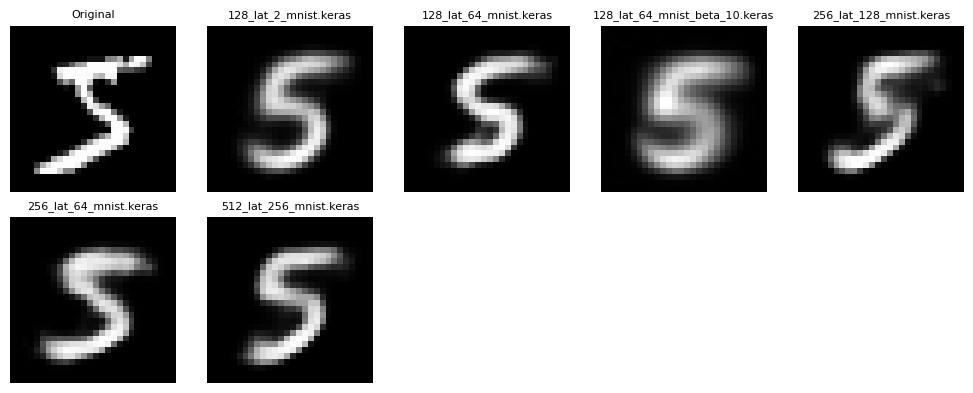

In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Agregar carpeta raíz al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Importar módulos propios
from Datos.Data_acq import get_mnist_data
from models_definitions.cvae import CVAE
from custom_layers.Sampling import Sampling

# Cargar datos
x_train, x_test, x_val, y_train, y_test, y_val, x_train_1, y_train_1 = get_mnist_data()

# Rutas a los modelos
ENCODER_DIR = "../../modelos_entrenados/encoders/"
DECODER_DIR = "../../modelos_entrenados/decoders/"
ORIGINAL_DIM = 28 * 28

# Obtener listas de archivos
encoder_files = sorted(os.listdir(ENCODER_DIR))
decoder_files = sorted(os.listdir(DECODER_DIR))

# Función para extraer clave
def get_key(filename):
    return "_".join(filename.split("_")[2:])  # ej: 'lat_2_mnist.keras'

# Crear diccionarios clave → path
encoders = {get_key(f): os.path.join(ENCODER_DIR, f) for f in encoder_files if f.endswith(".keras")}
decoders = {get_key(f): os.path.join(DECODER_DIR, f) for f in decoder_files if f.endswith(".keras")}

# Claves comunes entre encoder y decoder
common_keys = sorted(set(encoders.keys()) & set(decoders.keys()))
print(f"Encontrados {len(common_keys)} pares de modelos.")

# Imagen original
x_input = x_train[:1]         # Imagen original
cond_input = y_train[:1]      # Condición
original_image = x_input[0].reshape(28, 28)

# Guardar imágenes reconstruidas + nombres
reconstructed_images = [original_image]
model_names = ["Original"]

# Iterar sobre modelos
for key in common_keys:
    print(f"\n🧩 Cargando modelos para configuración: {key}")
    
    encoder_path = encoders[key]
    decoder_path = decoders[key]
    
    encoder = load_model(encoder_path, custom_objects={"Sampling": Sampling})
    decoder = load_model(decoder_path)

    cvae = CVAE(encoder, decoder, original_dim=ORIGINAL_DIM)
    cvae.compile(optimizer="adam")

    # Codificar y decodificar
    z_mean, z_log_var, z = cvae.encoder.predict([x_input, cond_input],verbose=0)
    reconstructed = cvae.decoder.predict([z, cond_input],verbose=0)

    # Guardar imagen
    reconstructed_images.append(reconstructed[0].reshape(28, 28))
    model_names.append(key)

    print(f"✅ Modelo '{key}' procesado.")

# Mostrar todas las imágenes en una sola figura
num_images = len(reconstructed_images)
cols = min(5, num_images)
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(cols * 2, rows * 2))

for i, (img, name) in enumerate(zip(reconstructed_images, model_names)):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(name, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


Si bien se observar diferencias apreciables en cada modelo, no parece haber un modelo que genere una reconstrucción mejor apreciablemetne mejor

# Error de reconstrucción por modelo

In [21]:

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Agregar carpeta raíz al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Importar módulos propios
from data.get_data import get_mnist_data
from models_definitions.cvae import CVAE
from custom_layers.Sampling import Sampling
from experiments.load import load_all_models

models = load_all_models()
data = get_mnist_data(dataset="mnist")
x_test = data["x_test"]
y_test = data["y_test"]


x_sample = x_test[:10000]
y_sample = y_test[:10000]

reconstruction_errors = []

for i, model in enumerate(models):
    # Generar reconstruccione
    reconstructions = model.predict((x_sample, y_sample), verbose=0)

    # Calcular error de reconstrucción promedio (MSE)
    mse = tf.reduce_mean(
        tf.keras.losses.mse(
            tf.reshape(x_sample, [x_sample.shape[0], -1]),
            tf.reshape(reconstructions, [reconstructions.shape[0], -1])
        )
    ).numpy()

    reconstruction_errors.append(mse)
    print(f"Modelo {i}: reconstruction MSE = {mse:.4f}")


Encontrados 6 pares de modelos.
Usando mnist como dataset
Modelo 0: reconstruction MSE = 0.0347
Modelo 1: reconstruction MSE = 0.0230
Modelo 2: reconstruction MSE = 0.0532
Modelo 3: reconstruction MSE = 0.0221
Modelo 4: reconstruction MSE = 0.0214
Modelo 5: reconstruction MSE = 0.0217


Hay un menor error de reconstrucción con forme crece el el número de paramentros. Sin embargo no parece haber una diferencia apreciable para los modelos de 256-128 y de 512-256. El error de reconstrucción es practicamente el mismo. 

Repetimos para Fashion

In [6]:

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Agregar carpeta raíz al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Importar módulos propios
from data.get_data import get_mnist_data
from models_definitions.cvae import CVAE
from custom_layers.Sampling import Sampling
from experiments.load import load_all_models

models = load_all_models(encoders_paths="../../trained_models/encoders_fashion",decoders_paths="../../trained_models/decoders_fashion")
data = get_mnist_data(dataset="fashion")
x_test = data["x_test"]
y_test = data["y_test"]


x_sample = x_test[:10000]
y_sample = y_test[:10000]

reconstruction_errors = []

for i, model in enumerate(models):
    # Generar reconstruccione
    reconstructions = model.predict((x_sample, y_sample), verbose=0)

    # Calcular error de reconstrucción promedio (MSE)
    mse = tf.reduce_mean(
        tf.keras.losses.mse(
            tf.reshape(x_sample, [x_sample.shape[0], -1]),
            tf.reshape(reconstructions, [reconstructions.shape[0], -1])
        )
    ).numpy()

    reconstruction_errors.append(mse)
    print(f"Modelo {i}: reconstruction MSE = {mse:.4f}")


Encontrados 6 pares de modelos.
Usando fashion como dataset
Modelo 0: reconstruction MSE = 0.0206
Modelo 1: reconstruction MSE = 0.0260
Modelo 2: reconstruction MSE = 0.0219
Modelo 3: reconstruction MSE = 0.0239
Modelo 4: reconstruction MSE = 0.0201
Modelo 5: reconstruction MSE = 0.0201


El modelo 0, 3 y 4  tiene un rendimiento muy similiar ( 128-2 512-128  y 1024-256). Parecen ser los más optimos para esto.

## Evaluación de separación 

In [5]:

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import load_model
# Agregar carpeta raíz al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Importar módulos propios
from data.get_data import get_mnist_data
from models_definitions.cvae import CVAE
from custom_layers.Sampling import Sampling
from custom_layers.ReshapeLayer import ReshapeLayer

from experiments.load import load_all_models
from inference.inference import unmix

models = load_all_models(encoders_paths="../../trained_models/encoders_fashion",decoders_paths="../../trained_models/decoders_fashion")
predictor = load_model("../../trained_models/predictores/CCE_Conv2D_fashion.keras", custom_objects={"ReshapeLayer": ReshapeLayer})
data = get_mnist_data(dataset="fashion")


x_test = data["x_test"]
y_test = data["y_test"]
x_test_1 = data["x_test_1"]
y_test_1 = data["y_test_1"]

num_images = 1000
x_sample = x_test[:num_images]
y_sample = y_test[:num_images]
x_sample = x_test_1[:num_images]
y_sample = y_test_1[:num_images]


bpsnrs = []

for i, model in enumerate(models):
    # Generar reconstruccione
    metrics = unmix(x_test[:num_images],
    x_test_1[:num_images],
    y_test[:num_images],
    y_test_1[:num_images],
    model,
    predictor,
    Iterations=3
    )


    bpsnrs.append(metrics["bpsnr"][0])
    print(f"Modelo {i}: bpsnr = {metrics["bpsnr"][0]:.4f}")


Encontrados 6 pares de modelos.
Usando fashion como dataset
Modelo 0: bpsnr = 15.1932
Modelo 1: bpsnr = 14.5006
Modelo 2: bpsnr = 14.9072
Modelo 3: bpsnr = 14.9583
Modelo 4: bpsnr = 15.1399
Modelo 5: bpsnr = 15.0992


Encontrados 6 pares de modelos.
Usando fashion como dataset
Modelo 0: bpsnr = 15.1932
Modelo 1: bpsnr = 14.5006
Modelo 2: bpsnr = 14.9072
Modelo 3: bpsnr = 14.9583
Modelo 4: bpsnr = 15.1399
Modelo 5: bpsnr = 15.0992

Con lo smodelos de fashion mnist, vemos que el el modelo número 1 (128-64) tiene la mejor bpsnr. 

In [7]:

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import load_model
# Agregar carpeta raíz al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

# Importar módulos propios
from data.get_data import get_mnist_data
from models_definitions.cvae import CVAE
from custom_layers.Sampling import Sampling
from custom_layers.ReshapeLayer import ReshapeLayer

from experiments.load import load_all_models
from inference.inference import unmix

models = load_all_models()
predictor = load_model("../../trained_models/predictores/CCE_Conv2D.keras", custom_objects={"ReshapeLayer": ReshapeLayer})
data = get_mnist_data()


x_test = data["x_test"]
y_test = data["y_test"]
x_test_1 = data["x_test_1"]
y_test_1 = data["y_test_1"]

num_images = 1000
x_sample = x_test[:num_images]
y_sample = y_test[:num_images]
x_sample = x_test_1[:num_images]
y_sample = y_test_1[:num_images]


bpsnrs = []

for i, model in enumerate(models):
    # Generar reconstruccione
    metrics = unmix(x_test[:num_images],
    x_test_1[:num_images],
    y_test[:num_images],
    y_test_1[:num_images],
    model,
    predictor,
    Iterations=3
    )


    bpsnrs.append(metrics["bpsnr"][0])
    print(f"Modelo {i}: bpsnr = {metrics["bpsnr"][0]:.4f}")


Encontrados 6 pares de modelos.
Usando mnist como dataset
Modelo 0: bpsnr = 15.2590
Modelo 1: bpsnr = 16.8237
Modelo 2: bpsnr = 13.7698
Modelo 3: bpsnr = 17.0152
Modelo 4: bpsnr = 17.1061
Modelo 5: bpsnr = 17.0936


Encontrados 6 pares de modelos.
Usando mnist como dataset
Modelo 0: bpsnr = 15.2590
Modelo 1: bpsnr = 16.8237
Modelo 2: bpsnr = 13.7698
Modelo 3: bpsnr = 17.0152
Modelo 4: bpsnr = 17.1061
Modelo 5: bpsnr = 17.0936


con estos experimientos parece ser que el mejor modelo para esta tarea es el modelo de 128-64 parametros 

2025-08-19 22:55:44.353706: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 22:55:44.357469: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 22:55:44.369451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755654944.389780  210421 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755654944.395641  210421 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755654944.410755  210421 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Encontrados 6 pares de modelos.


E0000 00:00:1755654946.712460  210421 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1755654946.712929  210421 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Usando fashion como dataset


2025-08-19 22:56:06.957725: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 282240000 exceeds 10% of free system memory.


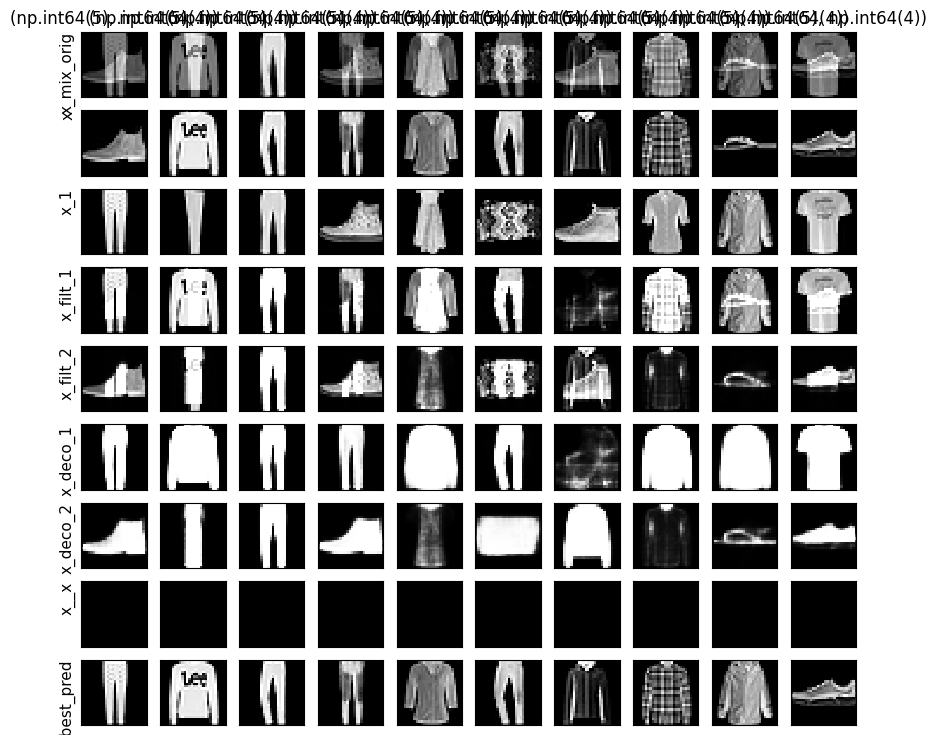

array([[3.54287039e-07, 4.88133423e-07, 5.79111315e-07, 3.24435791e-06,
        9.35281878e-06, 6.29979013e-06, 1.29826267e-05, 5.76844195e-06,
        1.35454420e-05, 8.37812331e-05, 2.26088348e-04, 4.88371181e-04,
        5.52860962e-04, 4.76453191e-04, 6.33414485e-04, 3.55968630e-04,
        2.52720580e-04, 2.72389763e-04, 1.20447898e-04, 1.73021981e-05,
        4.69943097e-06, 1.44329024e-05, 2.26255020e-06, 6.55043436e-07,
        2.58453792e-06, 1.33476064e-07, 1.45637586e-07, 3.26096114e-07,
        3.50479212e-07, 2.94648750e-08, 4.50206244e-06, 5.86856004e-06,
        1.24008136e-06, 6.95689209e-07, 3.06402490e-06, 1.07260355e-04,
        2.20713642e-04, 3.27621761e-04, 2.30655787e-04, 5.50960831e-04,
        6.04927598e-04, 4.65008226e-04, 4.70402068e-04, 6.06753631e-04,
        4.44287900e-04, 1.15613366e-04, 2.37269429e-04, 2.61953945e-04,
        1.15615570e-04, 8.56079441e-06, 3.00434635e-06, 1.09483187e-06,
        2.74102240e-06, 3.27371322e-06, 1.65952736e-06, 1.821476

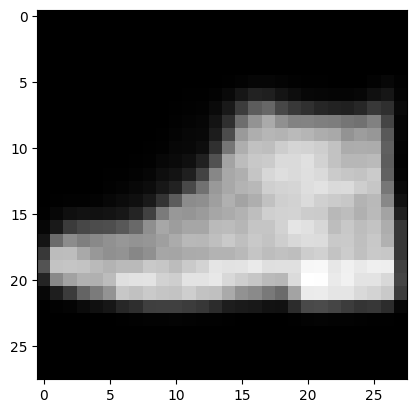

In [1]:
import os
import sys
import numpy as np
# Agregar carpeta raíz al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from experiments import load
from tensorflow.keras.models import load_model
from custom_layers.ReshapeLayer import ReshapeLayer
from data.get_data import get_mnist_data



models = load.load_all_models(encoders_paths="../../trained_models/encoders_fashion",decoders_paths="../../trained_models/decoders_fashion")
predictor = load_model("../../trained_models/predictores/CCE_Conv2D_fashion.keras", custom_objects={"ReshapeLayer": ReshapeLayer})
data = get_mnist_data(dataset="fashion")


from CROP_models.crop import crop

crop_0 = crop(models[0], predictor, data)

x_test = data["x_test"]
y_test = data["y_test"]
x_test_1 = data["x_test_1"]
y_test_1 = data["y_test_1"]


crop_0.unmix(x=x_test,x_1=x_test_1,y=y_test,y_1=y_test_1,show_graph=True)


# Imagen original
x_input = x_test[:1]         # Imagen original
cond_input = y_test[:1]      # Condición
original_image = x_input[0].reshape(28, 28)

crop_0.reconstruct(x_input,cond_input)


ImportError: module crop not in sys.modules